In [1]:
using HDF5
using Plots
using LadderDGA
using Suppressor
using Logging

#path_to_input = "/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s0_b12_u1.0"
#path_to_output = "$(@__DIR__)/../../lDGA_test_runs"
cfg_file = "$(@__DIR__)/../../lDGA_test_runs/config_large.toml"
cfg_file2 = "$(@__DIR__)/../../lDGA_test_runs/config_large2.toml"

empty!(ARGS);
#push!(ARGS,path_to_input);
#push!(ARGS,path_to_output);
#include("../scripts/triqs_conv.jl");

io = stdout
metafmt(level::Logging.LogLevel, _module, group, id, file, line) = Logging.default_metafmt(level, nothing, group,     id, nothing, nothing)
logger = ConsoleLogger(io, Logging.Info, meta_formatter=metafmt, show_limited=true, right_justify=0)
global_logger(logger);

┌ Info: Precompiling LadderDGA [78e40beb-bf89-4c0e-9d2b-bee278912f2b]
└ @ Base loading.jl:1317


Loading impurity quantities and constructing k grids.
removing the @supress block activates debugging output.

In [2]:
mP, sP, env, kGrids, qGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file)
kG = kGrids[1]
qG = qGrids[1]
νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp_fft, GLoc_fft, Σ_loc, FUpDo, gImp, gLoc = setup_LDGA(kG, freqList, mP, sP, env);

mP2, sP2, env2, kGrids, qGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file2)
νGrid2, sumHelper_f2, impQ_sp2, impQ_ch2, GImp_fft2, GLoc_fft2, Σ_loc2, FUpDo2, gImp2, gLoc2 = setup_LDGA(kG, freqList, mP2, sP2, env2);

[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
[ Warning: assuming ED calculation for E_kin!! gm_wim and hubb.andpar need to be present
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities iwth ranges are:
│ χLoc_sp(38:64) = 0.3182, χLoc_ch(38:64) = 0.1222 
└ sum χupup check: 0.23524970649411947 ?≈? 0.25"
[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
[ Warning: assuming ED calculation for E_kin!! gm_wim and hubb.andpar need to be present
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities iwth ranges are:
│ χLoc_sp(2:100) = 0.315, χLoc_ch(2:100) = 0.1071 
└ sum χupup check: 0.24968657431466687 ?≈? 0.25"


# Lambda charge solutions investigation

In [3]:
# "local" correction quantities
bubbleLoc = calc_bubble(νGrid, GImp_fft, qGridLoc, mP, sP);
locQ_sp = calc_χ_trilex(impQ_sp.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, mP.U, mP, sP);
locQ_ch = calc_χ_trilex(impQ_ch.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, -mP.U, mP, sP);
Σ_ladderLoc = calc_Σ(locQ_sp, locQ_ch, bubbleLoc, GImp_fft, FUpDo,
                     qGridLoc, sumHelper_f, mP, sP)
Σ_ladderLoc = Σ_ladderLoc .+ mP.n * mP.U/2.0;

In [4]:
# non local quantities 
bubble = calc_bubble(νGrid, GLoc_fft, qG, mP, sP);
nlQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble, qG, νGrid, sumHelper_f, mP.U, mP, sP);
nlQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble, qG, νGrid, sumHelper_f, -mP.U, mP, sP);

In [5]:
# non local quantities 
bubble2 = calc_bubble(νGrid, GLoc_fft2, qG, mP2, sP2);
nlQ_sp2 = calc_χ_trilex(impQ_sp2.Γ, bubble2, qG, νGrid, sumHelper_f2, mP2.U, mP2, sP2);
nlQ_ch2 = calc_χ_trilex(impQ_ch2.Γ, bubble2, qG, νGrid, sumHelper_f2, -mP2.U, mP2, sP2);

In [6]:
sh_1 = LadderDGA.get_sum_helper(nlQ_sp.usable_ω, sP, :b)
χspw = LadderDGA.sum_freq(LadderDGA.kintegrate(qG, nlQ_sp.χ[nlQ_sp.usable_ω,:], dim=2)[:,1], [1], sh_1, mP.β)[1]
sh_1 = LadderDGA.get_sum_helper(nlQ_ch.usable_ω, sP, :b)
χchw = LadderDGA.sum_freq(LadderDGA.kintegrate(qG, nlQ_ch.χ[nlQ_ch.usable_ω,:], dim=2)[:,1], [1], sh_1, mP.β)[1]


sh_12 = LadderDGA.get_sum_helper(nlQ_sp2.usable_ω, sP2, :b)
χspw2 = LadderDGA.sum_freq(LadderDGA.kintegrate(qG, nlQ_sp2.χ[nlQ_sp2.usable_ω,:], dim=2)[:,1], [1], sh_12, mP2.β)[1]

sh_12 = LadderDGA.get_sum_helper(nlQ_ch2.usable_ω, sP2, :b)
χchw2 = LadderDGA.sum_freq(LadderDGA.kintegrate(qG, nlQ_ch2.χ[nlQ_ch2.usable_ω,:], dim=2)[:,1], [1], sh_12, mP2.β)[1]

usable_upup = intersect(nlQ_ch2.usable_ω,nlQ_sp2.usable_ω)
χupup_sum = LadderDGA.sum_freq(LadderDGA.kintegrate(qG,nlQ_sp2.χ[usable_upup,:] .+ nlQ_ch2.χ[usable_upup,:], dim=2)[:,1], [1], sh_12, mP2.β)[1]

println("ntc: $(real(χspw)) + $(real(χchw)) = $(real(χspw + χchw))")
println("rtc: $(real(χspw2)) + $(real(χchw2)) = $(real(χspw2 + χchw2))")

#plot(nlQ_sp.usable_ω, real(impQ_sp.χ_ω[impQ_sp.usable_ω]))
#plot!(nlQ_sp2.usable_ω, real(impQ_sp2.χ_ω[impQ_sp2.usable_ω]))

ntc: 0.3305163330949948 + 0.12097061432070942 = 0.4514869474157042
rtc: 0.34886476254687676 + 0.13078723267129058 = 0.47965199521816737


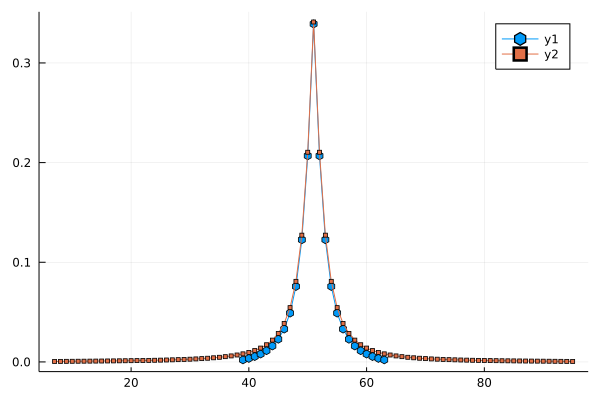

In [7]:

kintegrate = LadderDGA.kintegrate
sum_freq = LadderDGA.sum_freq
χ_λ(χ::AbstractArray, λ::Union{Float64}) = map(χi -> 1.0 / ((1.0 / χi) + λ), χ)
kGrid = qG
β = mP.β



sh = get_sum_helper(nlQ_ch.usable_ω, sP, :b)
χch_ω = kintegrate(kGrid, nlQ_ch.χ, dim=2)[:,1]
χch_sum = real(sum_freq(χch_ω[nlQ_ch.usable_ω], [1], sh, mP.β)[1])
χsp_ω = kintegrate(kGrid, nlQ_sp.χ, dim=2)[:,1]
χsp_sum = real(sum_freq(χsp_ω[nlQ_sp.usable_ω], [1], sh, mP.β)[1])
usable_ω = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)

sh_2 = get_sum_helper(nlQ_ch2.usable_ω, sP2, :b)
χch_ω_2 = kintegrate(kGrid, nlQ_ch2.χ, dim=2)[:,1]
χch_sum_2 = real(sum_freq(χch_ω_2[nlQ_ch2.usable_ω], [1], sh_2, mP2.β)[1])
χsp_ω_2 = kintegrate(kGrid, nlQ_sp2.χ, dim=2)[:,1]
χsp_sum_2 = real(sum_freq(χsp_ω_2[nlQ_sp2.usable_ω], [1], sh_2, mP2.β)[1])
usable_ω_2 = intersect(nlQ_sp2.usable_ω, nlQ_ch2.usable_ω)

plot(nlQ_ch.usable_ω, real(χch_ω[nlQ_ch.usable_ω]),markershape = :hexagon,markersize = 4)
plot!(nlQ_ch2.usable_ω, real(χch_ω_2[nlQ_ch2.usable_ω]),markershape = :square,markersize = 2)

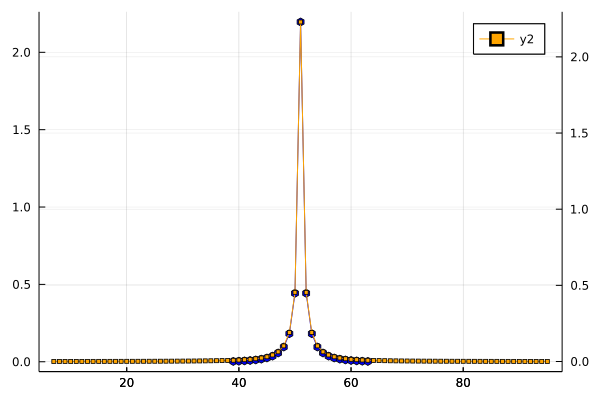

In [8]:
plot(nlQ_sp.usable_ω, real(χsp_ω[nlQ_sp.usable_ω]),markershape = :hexagon,markersize = 4,c=:blue)
plot!(twinx(),[i for i in nlQ_sp2.usable_ω if i != 510], real(χsp_ω_2[[i for i in nlQ_sp2.usable_ω if i != 510]]), c=:orange,markershape = :square,markersize = 2)

In [9]:
λ_sp, λ_spch  = λ_correction!(impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, qG, νGrid, mP, sP)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(39:63,39:63) = 39:63 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 39:63, length: 25
│ ch: 39:63, length: 25
│ usable: 39:63, length: 25
└ χch sum = 0.13722446501259464, rhs = 0.3031729425529529
┌ Info: found 
│   χ_min = -0.09022526652199893
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.09022526652199893, 1.8045053304399785]"
┌ Info: Method 2 root:
│   r2 =
│    1-element Vector{Float64}:
└     0.11048212802018624
┌ Info: Found λsp 
└   λsp_old = 0.11048212801684054
[ Info: new lambda correction: λsp=0.0 and λch=0.0


(0.11048212801684054, [0.0, 0.0], [-0.09022526652199893, 1.8045053304399785], [-Inf, Inf])

In [10]:
λ_sp2, λ_spch2  = λ_correction!(impQ_sp2, impQ_ch2, FUpDo2, Σ_loc2, Σ_ladderLoc, nlQ_sp2, nlQ_ch2, bubble2, GLoc_fft2, qG, νGrid, mP2, sP2)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(7:95,7:95) = 7:95 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 7:95, length: 89
│ ch: 7:95, length: 89
│ usable: 7:95, length: 89
└ χch sum = 0.14799858896682708, rhs = 0.35200141103317295
┌ Info: found 
│   χ_min = -0.08908315137729711
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.08908315137729711, 1.7816630275459422]"
┌ Info: Method 2 root:
│   r2 =
│    1-element Vector{Float64}:
└     0.022696469688844728
┌ Info: Found λsp 
└   λsp_old = 0.022696469688344448
[ Info: new lambda correction: λsp=0.0 and λch=0.0


(0.022696469688344448, [0.0, 0.0], [-0.08908315137729711, 1.7816630275459422], [-Inf, Inf])

In [11]:
χsp = 1 ./ ( (1 ./ nlQ_sp.χ) .- nlQ_sp.λ);
χsp2 = 1 ./ ( (1 ./ nlQ_sp2.χ) .- nlQ_sp2.λ);
χr = real.(χsp[nlQ_sp.usable_ω, :]);
χr2 = real.(χsp2[nlQ_sp2.usable_ω, :]);

In [25]:
sh = get_sum_helper(usable_ω, sP, :b)
sh2 = get_sum_helper(nlQ_sp2.usable_ω, sP2, :b)


iωn = 1im .* 2 .* (-sP.n_iω:sP.n_iω)[nlQ_sp2.usable_ω] .* π ./ mP.β
EKin = impQ_sp.tailCoeffs[3]
f(x) = sum_freq(kintegrate(qG, χ_λ(χr, x), dim=2)[:,1], [1], sh, mP.β)[1] - 0.3194267932448381
f2(x) = sum_freq(LadderDGA.subtract_tail(kintegrate(qG, χ_λ(χr2, x), dim=2)[:,1],EKin, iωn), [1], LadderDGA.Naive(), mP.β, corr=-EKin*mP.β^2/12)[1] - 0.35200141103317295
f3(x) = sum_freq(kintegrate(qG, χ_λ(χr2, x), dim=2)[:,1], [1], sh, mP.β)[1] - 0.36415246809110613 

f3 (generic function with 1 method)

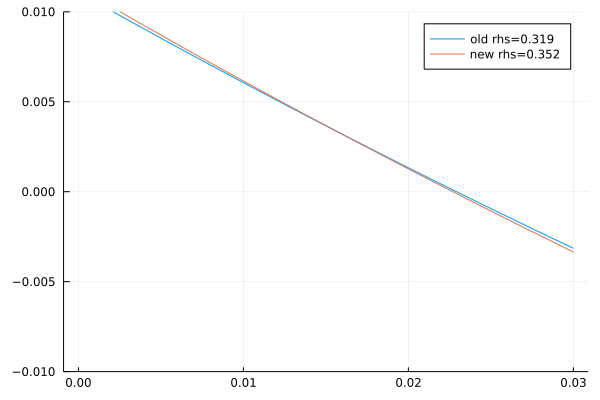

In [63]:
xarr = 0.0:0.0001:0.03
#xarr =  0.028:0.0001:0.032

plot(xarr,f.(xarr), label="old rhs=0.319", ylim=(-0.01,0.01))
plot!(xarr,f2.(xarr), label="new rhs=0.352")


In [14]:
sh = get_sum_helper(2*sP.n_iν, sP2, :f)

#test = sum_freq(impQ_sp.χ .+ impQ_ch.χ,[2,3],sh,mP2.β)[:,1,1]
test1 = sum_freq(impQ_sp.χ,[2,3],sh,mP2.β)[:,1,1]
test2 = sum_freq(impQ_ch.χ,[2,3],sh,mP2.β)[:,1,1]
r1 = LadderDGA.find_usable_interval(real.(test1),reduce_range_prct=0.1)[:,1,1]
r2 = LadderDGA.find_usable_interval(real.(test2),reduce_range_prct=0.1)[:,1,1]
sh2_1 = get_sum_helper(r1, sP2, :b)
sh2_2 = get_sum_helper(r2, sP2, :b)
sum_freq(test1[r1], [1], sh2_1,mP2.β) .+ sum_freq(test2[r2], [1], sh2_2,mP2.β)

0.4680014812452763 - 5.267438540530422e-10im

In [15]:
sh = get_sum_helper(2*sP.n_iν, sP2, :f)

test = sum_freq(impQ_sp2.χ .+ impQ_ch2.χ,[2,3],sh,mP2.β)[:,1,1]
r1 = LadderDGA.find_usable_interval(real.(test),reduce_range_prct=-0.1)[:,1,1]
sh2 = get_sum_helper(r1, sP2, :b)
sum_freq(test[r1], [1], sh2_1,mP2.β)

LoadError: BoundsError: attempt to access 101-element Vector{ComplexF64} at index [[-4, -3, -2, -1, 0, 1, 2, 3, 4, 5  …  97, 98, 99, 100, 101, 102, 103, 104, 105, 106]]

In [16]:

r = intersect(impQ_sp2.usable_ω, impQ_ch2.usable_ω)
sh2 = get_sum_helper(r, sP2, :b)
sum_freq(impQ_sp2.χ_ω[r] .+ impQ_ch2.χ_ω[r], [1], sh2,mP2.β )

0.42205255451714646 - 5.267437992880211e-10im

In [17]:
χr = real.(χsp[nlQ_sp.usable_ω, :]);
χr2 = real.(χsp2[nlQ_sp2.usable_ω, :]);
rhs = 0.36415246809110613
sh2 = get_sum_helper(nlQ_sp2.usable_ω, sP2, :b)
f(λint) = sum_freq(kintegrate(kGrid, χ_λ(χr2, λint), dim=2)[:,1], [1], sh2, mP2.β)[1] - rhs
df(λint) = sum_freq(kintegrate(kGrid, -χ_λ(χr2, λint) .^ 2, dim=2)[:,1], [1], sh2, mP2.β)[1]
χ_min = -0.08920733408245121
-0.08920733408245121

-0.08920733408245121

In [18]:
function newton_right(χr::Array{Float64,2}, f::Function, df::Function,
                            start::Float64; nsteps=5000, atol=1e-8)
    done = false
    δ = 0.001
    x0 = start + δ
    xi = x0
    i = 1
            d=10
    while !done
        fi = f(xi)
        dfi = df(xi)
        xlast = xi
        xi = x0 - fi / dfi
        println("$(i): f($(round(xi,digits=d)))=$(round(fi,digits=d)), df=$(round(dfi,digits=d))")
        if xi ≈ x0
            break
        end
        if xi < x0               # only ever search to the right!
            println("reset xi=$xi x0=$x0")
            δ  = δ/2.0
            x0  = start + δ      # reset with smaller delta
            xi = x0
        else
            x0 = xi
        end
        (i >= nsteps ) && (done = true)
        i += 1

    end
    
    return xi
end


newton_right (generic function with 1 method)

In [19]:
newton_right(χr2,f,df,χ_min)

1: f(-0.0872597591)=0.4774163164, df=-503.8295914585
2: f(-0.0851409625)=0.2476799653, df=-116.8965270737
3: f(-0.0799919208)=0.1321599923, df=-25.6669107299
4: f(-0.0667505259)=0.0724891678, df=-5.4744359048
5: f(-0.0419896785)=0.0371843816, df=-1.5017410763
6: f(-0.0273906535)=0.0115342249, df=-0.7900681645
7: f(-0.0259068079)=0.0009880788, df=-0.6658905503
8: f(-0.0258960048)=7.0911e-6, df=-0.6564016285
9: f(-0.0258960043)=4.0e-10, df=-0.6563340388
10: f(-0.0258960043)=-0.0, df=-0.6563340353


-0.025896004287113944

In [20]:
using Roots

get_sum_helper = LadderDGA.get_sum_helper
kintegrate = LadderDGA.kintegrate
sum_freq = LadderDGA.sum_freq
χ_λ(χ::AbstractArray, λ::Union{Float64}) = map(χi -> 1.0 / ((1.0 / χi) + λ), χ)
kGrid = qG
β = mP.β


sh = get_sum_helper(nlQ_ch.usable_ω, sP, :b)
χch_ω = kintegrate(kGrid, nlQ_ch.χ, dim=2)[:,1]
χch_sum = real(sum_freq(χch_ω[nlQ_ch.usable_ω], [1], sh, mP.β)[1])
rhs1 = mP.n * (1 - mP.n/2) - χch_sum
rhs2 = real(impQ_ch.χ_loc + impQ_sp.χ_loc - χch_sum)
usable_ω = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)
sh = get_sum_helper(usable_ω, sP, :b)
χupup_sum = sum_freq(kintegrate(kGrid, 0.5 .* (nlQ_ch.χ[usable_ω,:] .+ nlQ_sp.χ[usable_ω,:]), dim=2)[:,1], [1], sh, mP.β)[1]


sh_2 = get_sum_helper(nlQ_ch2.usable_ω, sP2, :b)
χch_ω_2 = kintegrate(kGrid, nlQ_ch2.χ, dim=2)[:,1]
χch_sum_2 = real(sum_freq(χch_ω_2[nlQ_ch2.usable_ω], [1], sh_2, mP2.β)[1])
rhs1_2 = mP.n * (1 - mP.n/2) - χch_sum_2
rhs2_2 = real(impQ_ch2.χ_loc + impQ_sp2.χ_loc - χch_sum_2)
usable_ω_2 = intersect(nlQ_sp2.usable_ω, nlQ_ch2.usable_ω)
sh_2 = get_sum_helper(usable_ω_2, sP2, :b)
χupup_sum_2 = sum_freq(kintegrate(kGrid, 0.5 .* (nlQ_ch2.χ[usable_ω_2,:] .+ nlQ_sp2.χ[usable_ω_2,:]), dim=2)[:,1], [1], sh_2, mP2.β)[1]

println("usable range: $usable_ω vs $usable_ω_2\nχupup_nc=$χupup_sum\nχupup_rc=$χupup_sum_2")

χ_in = nlQ_sp.χ
usable_ω_i = nlQ_sp.usable_ω
χr    = real.(χ_in[usable_ω_i,:])
sh = get_sum_helper(usable_ω_i, sP, :b)
f(λint) = sum_freq(kintegrate(kGrid, χ_λ(χr, λint), dim=2)[:,1], [1], sh, β)[1] - rhs2
df(λint) = sum_freq(kintegrate(kGrid, -χ_λ(χr, λint) .^ 2, dim=2)[:,1], [1], sh, β)[1]
r2 = find_zeros(f, 0.02, 20.0, verbose=true)

χ_in = nlQ_sp2.χ
usable_ω_i = nlQ_sp2.usable_ω
χr    = real.(χ_in[usable_ω_i,:])
sh = get_sum_helper(usable_ω_i, sP2, :b)
f(λint) = sum_freq(kintegrate(kGrid, χ_λ(χr, λint), dim=2)[:,1], [1], sh, β)[1] - rhs1
df(λint) = sum_freq(kintegrate(kGrid, -χ_λ(χr, λint) .^ 2, dim=2)[:,1], [1], sh, β)[1]
r22 = find_zeros(f, 0.02, 20.0, verbose=true)

println("lambda $r2 vs $r22")

LoadError: cannot assign a value to variable LadderDGA.get_sum_helper from module Main

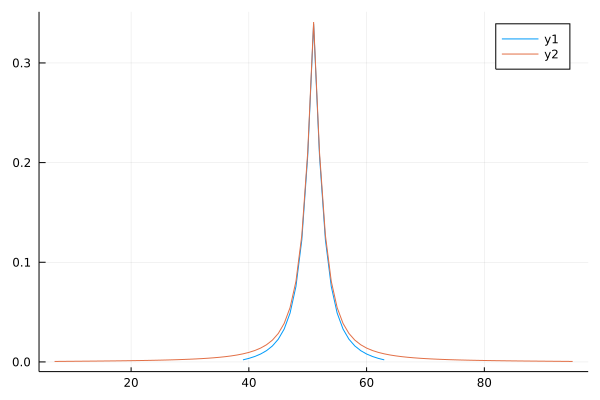

In [21]:
plot(usable_ω, real(χch_ω[usable_ω]))
plot!(usable_ω_2, real(χch_ω_2[usable_ω_2]))

In [22]:
length(usable_ω_2)

89

In [23]:
χupup_1 = nlQ

LoadError: UndefVarError: nlQ not defined

In [24]:
size(bubble)

(101, 20, 200)